Notebook to test the reimplementation of the Compton subtraction method, including helper functions. Written 20190708


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../")
import ompy

%load_ext autoreload
%matplotlib notebook

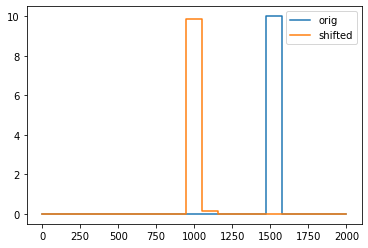

In [6]:
# Test the rebin_and_shift function

N = 20
E_array = np.linspace(0, 2000, N)
counts = np.zeros(N)
counts[15] = 10


counts_shifted = ompy.rebin_and_shift(counts, E_array_in=E_array, E_array_out=E_array, energy_shift=-525)


f, ax = plt.subplots(1)

ax.step(E_array, counts, label="orig")
ax.step(E_array, counts_shifted, label="shifted")

ax.legend()


plt.show()